# softmax classifier 分类器来解决多分类问题和实现

之前的是二分类问题即只有两种情况 只需要输出其中的一种概率P1 而P2 = 1-P1
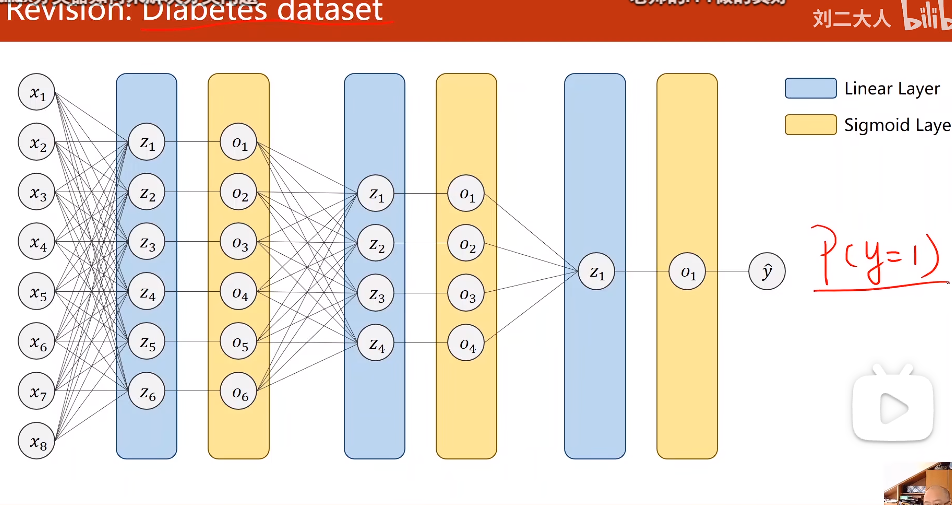
MNIST数据集则有10种可能性 即多分类问题
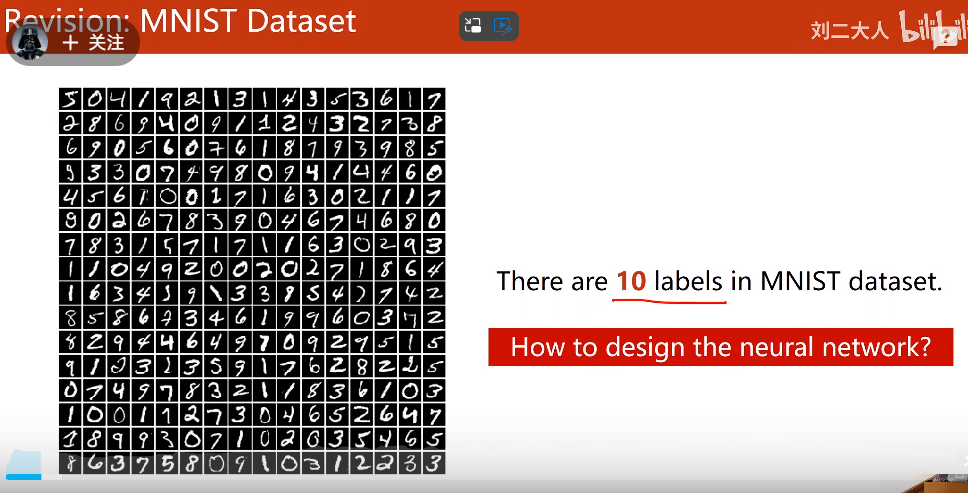
设计情况

1.在输出的时候有10个输出
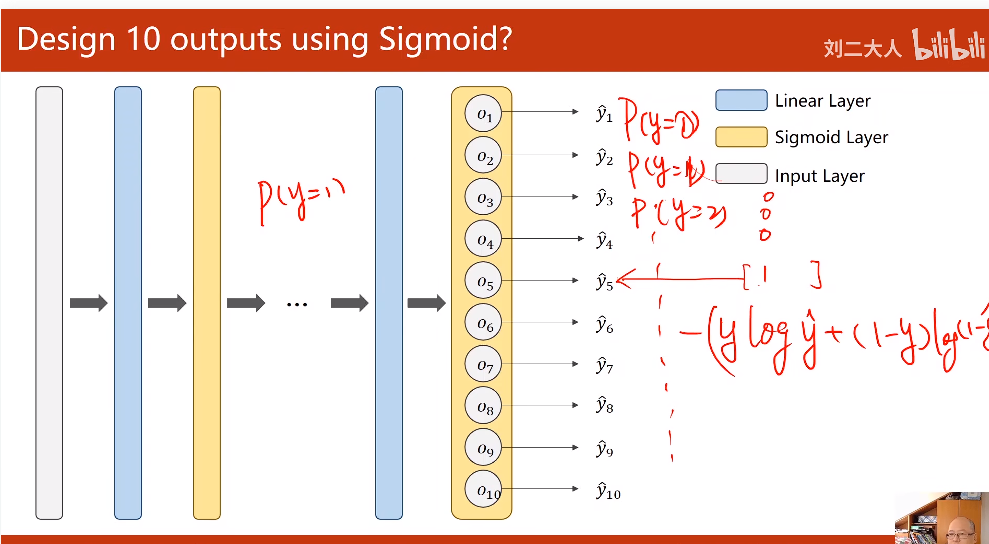
这种情况加起来不等于1 要满足下面两个条件
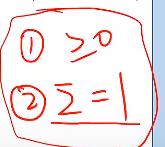
10个分类有9个参数就行了 最后一个分类用1来减去前面的 输出的应该是一个概率分布
我们需要加一个softmax层 这个层可以输出不同情况的概率 softmax上一层的神经网络得到的概率可能为正也可能为负
且相加不为1 故要经过进一步处理
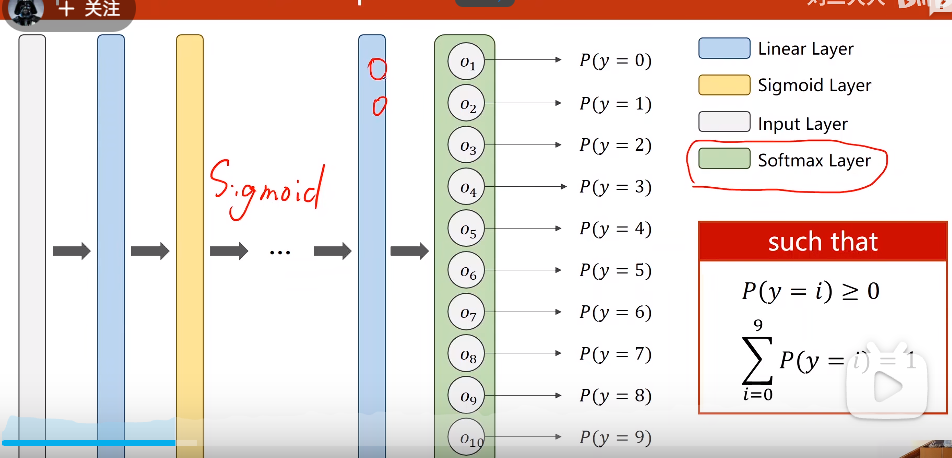

# softmax的实现

softmax层的公式 zi为上一层的输出 z1 z2 z3 .... zk-1

分子 来满足条件1
分母 来满足条件2
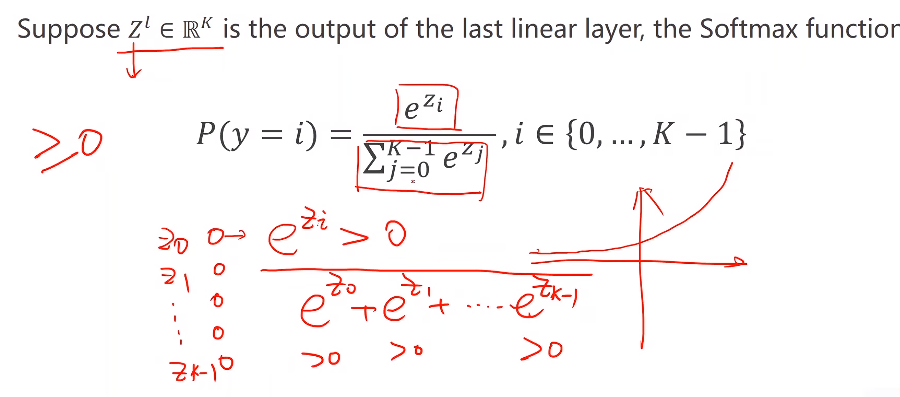

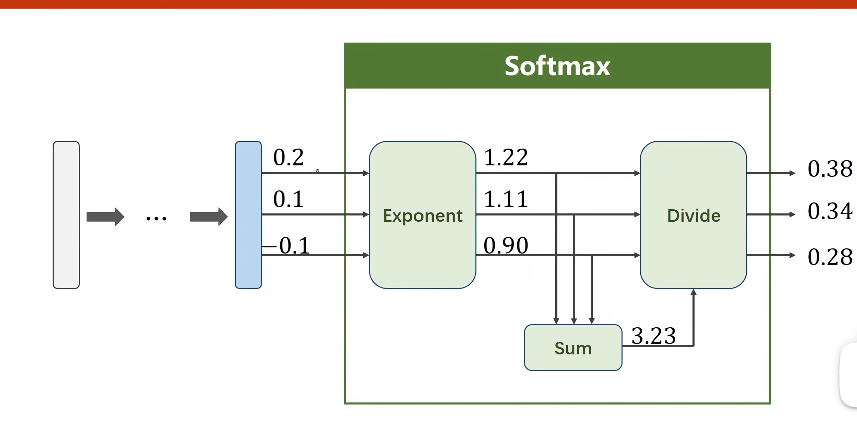

softmax后的损失函数怎么做

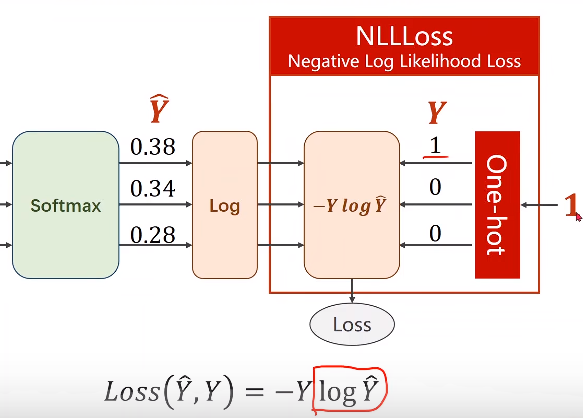
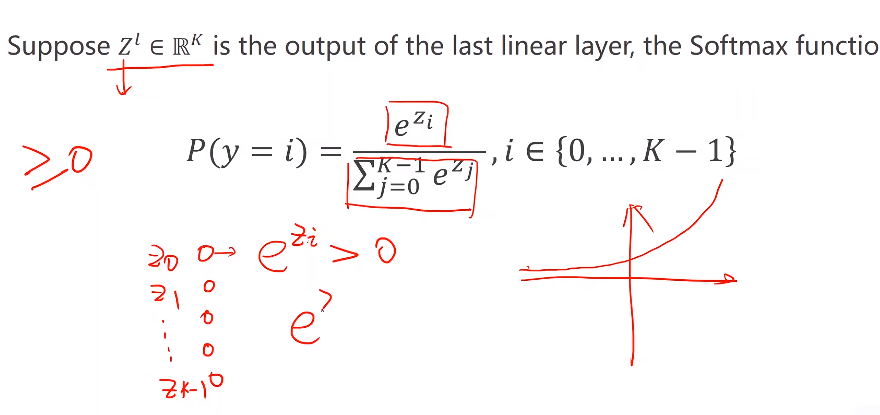

In [17]:
import numpy as np
y = np.array([1,0,0])
z = np.array([0.2,0.1,-0.1])

y_pred = np.exp(z)/np.exp(z).sum()

loss = (-y * np.log(y_pred)).sum()

print(loss)

#pytorch中有softmax函数 也有一个用的很多的 交叉熵损失函数

0.9729189131256584


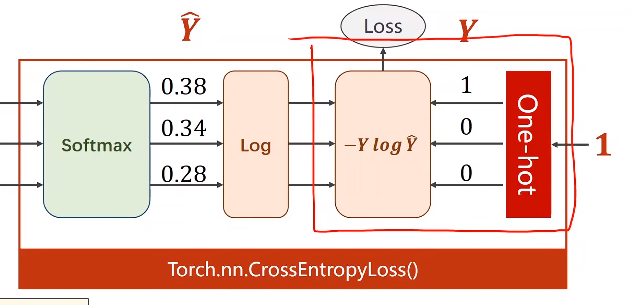
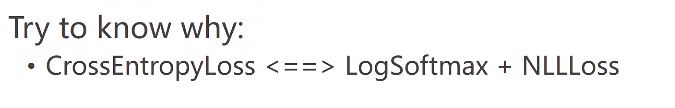

In [18]:
import torch

y = torch.LongTensor([0])
x = torch.Tensor([[0.2,0.1,-0.1]])
criterion = torch.nn.CrossEntropyLoss() #交叉熵函数计算损失
loss = criterion(x,y)
print(loss)

tensor(0.9729)


In [19]:
import torch
criterion = torch.nn.CrossEntropyLoss()
Y = torch.LongTensor([2,0,1]) #Y--结果有三种类型 分别是 2，0 ，1
Y_pred1 = torch.Tensor([[0.1,0.2,0.9],[1.1,0.1,0.2],[0.2,2.1,0.1]]) # 2 0 1 两个都是位置一致的一种预测
Y_pred2 = torch.Tensor([[0.8,0.2,0.3],[0.2,0.3,0.5],[0.2,0.2,0.5]]) #2 0 1

l1 = criterion(Y_pred1,Y)
l2 = criterion(Y_pred2,Y)

print("Batch loss1=",l1.data,"\nBatch loss2=",l2.data)

Batch loss1= tensor(0.4966) 
Batch loss2= tensor(1.2389)


# 用MNIST数据集做多分类
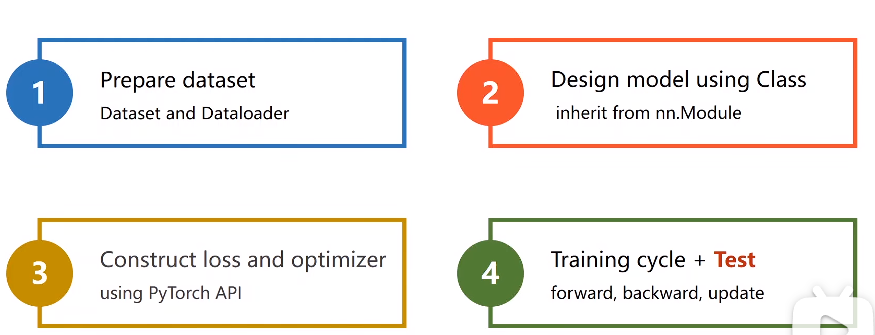
训练的最后加上了用测试集做测试

代码说明：1、第8讲 from torch.utils.data import Dataset，第9讲 from torchvision import datasets。该datasets里面init，getitem,len魔法函数已实现。

                  2、torch.max的返回值有两个，第一个是每一行的最大值是多少，第二个是每一行最大值的下标(索引)是多少。

                  3、全连接神经网络

                 4、torch.no_grad()   Python中with的用法

                5、代码中"_"的说明  Python中各种下划线的操作 

               6、torch.max( )的用法  torch.max( )使用讲解

In [43]:
import torch
from torchvision import transforms #针对图像做处理的包
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F #全链接层的激活函数relu（）函数
import torch.optim as optim #优化器的包



# 归一化,均值和方差这行代码定义了一个图像转换的管道，其中包含两个转换操作：

# transforms.ToTensor()：将图像转换为PyTorch张量（tensor），这是神经网络处理图像数据的标准方式。

# transforms.Normalize((0.1307,), (0.3081,))：对张量进行归一化操作，将张量的数值进行标准化处理。
# 在这里，(0.1307,) 是均值（mean）的元组，(0.3081,) 是标准差（standard deviation）的元组。
# 这个具体的均值和标准差是针对特定数据集（通常是MNIST）计算得到的，目的是将输入数据归一化到一个标准的范围内，有助于提高模型的训练效果。

# 综合起来，这个图像转换管道的作用是将图像转换为张量，并对张量进行归一化处理，以便用于神经网络的训练或推理过程中。


#准备数据


#训练数据集
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) # 归一化,均值和方差
 
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


设计模型
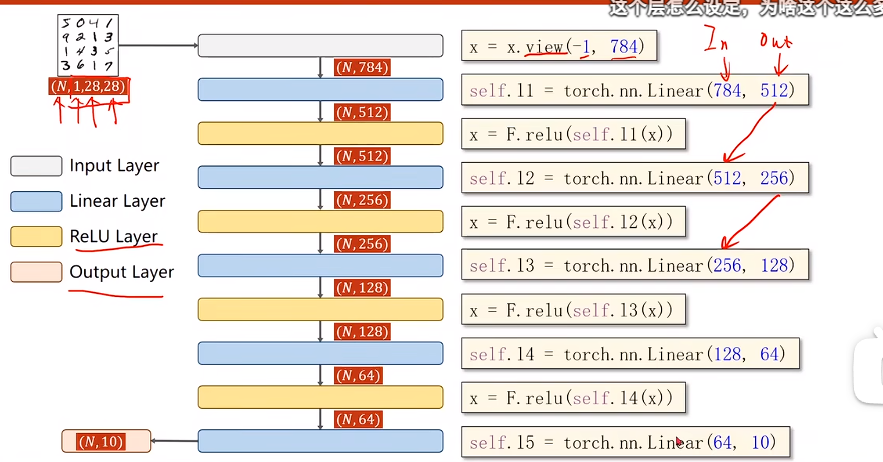

In [44]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
 
    def forward(self, x):
        x = x.view(-1, 784)  # -1其实就是自动获取mini_batch
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)  # 最后一层不做激活，不进行非线性变换
 
 
model = Net()

In [45]:
criterion = torch.nn.CrossEntropyLoss() #交叉熵损失
optimizer = optim.SGD(model.parameters(),lr = 0.01,momentum=0.5) #梯度下降优化算法 带冲量 = 0.5

In [46]:
def train(epoch): #将一轮循环封装成一个函数
    running_loss = 0.0
    for batch_idx,data in enumerate(train_loader,0):
        inputs,target = data
        optimizer.zero_grad() #优化器在优化前先清0
        
        #forward = backward + update
        outputs = model(inputs)
        loss = criterion(outputs,target)#loss(y^,y)
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + loss.item() #计算损失
        if batch_idx % 300 == 299: #每300轮输出一次
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0

In [47]:
def test(): 
    correct = 0 #正确的多少
    total = 0 #总数是多少
    with torch.no_grad(): #在下面部分的代码就不会在计算梯度
        for data in test_loader: #从testloader里面拿出数据 在做预测
            images,labels = data 
            outputs = model(images) 
            _, predicted = torch.max(outputs.data, dim=1) # dim = 1 列是第0个维度，行是第1个维度
            #下划线 _ 经常用作一个临时占位符，用于表示一个变量的值暂时不重要或不需要。在这个上下文中，_ 通常用于表示不关心的值，即忽略该值。
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
            # 张量之间的比较运算  #将推测出来的结果和本来结果作比较 相等就是真 不相等就是假
    print('accuracy on test set: %d %% ' % (100*correct/total))

In [53]:
import time
#中间写上代码块
start=time.time()
if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        test()
end=time.time()
print('Running time: %s Seconds'%(end-start))

[1,   300] loss: 2.178
[1,   600] loss: 0.809
[1,   900] loss: 0.400
accuracy on test set: 89 % 
[2,   300] loss: 0.312
[2,   600] loss: 0.254
[2,   900] loss: 0.222
accuracy on test set: 93 % 
[3,   300] loss: 0.180
[3,   600] loss: 0.159
[3,   900] loss: 0.153
accuracy on test set: 95 % 
[4,   300] loss: 0.128
[4,   600] loss: 0.120
[4,   900] loss: 0.109
accuracy on test set: 96 % 
[5,   300] loss: 0.098
[5,   600] loss: 0.093
[5,   900] loss: 0.092
accuracy on test set: 96 % 
[6,   300] loss: 0.077
[6,   600] loss: 0.073
[6,   900] loss: 0.071
accuracy on test set: 96 % 
[7,   300] loss: 0.062
[7,   600] loss: 0.059
[7,   900] loss: 0.061
accuracy on test set: 97 % 
[8,   300] loss: 0.047
[8,   600] loss: 0.049
[8,   900] loss: 0.052
accuracy on test set: 97 % 
[9,   300] loss: 0.041
[9,   600] loss: 0.039
[9,   900] loss: 0.043
accuracy on test set: 97 % 
[10,   300] loss: 0.033
[10,   600] loss: 0.030
[10,   900] loss: 0.036
accuracy on test set: 97 % 
Running time: 392.012580633